## Handwritten digit generation using Generative Adversarial Network (GAN)

### Standard Approach

In [1]:
#Importing all dependencies

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Flatten, BatchNormalization, Activation
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras import metrics
from keras import initializers
from scipy.stats import norm
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ReLU, PReLU, LeakyReLU,ELU
from tensorflow.keras import activations
from keras.layers.convolutional import Conv2D, Conv2DTranspose

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

Building Generator

In [3]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

Building Discriminator

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

Building the model

In [5]:
def build_gan(generator, discriminator):
    # Keep Discriminator’s parameters constant for Generator training
    discriminator.trainable = False
    
    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

Training

In [9]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    # X_train = X_train / 127.5 - 1.0
    X_train = (X_train - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------
        discriminator.trainable=True

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [10]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

1000 [D loss: 0.100827, acc.: 95.90%] [G loss: 5.064598]
2000 [D loss: 0.060207, acc.: 99.22%] [G loss: 5.181258]
3000 [D loss: 0.166473, acc.: 94.73%] [G loss: 5.388984]
4000 [D loss: 0.160010, acc.: 93.36%] [G loss: 5.026916]
5000 [D loss: 0.276514, acc.: 89.45%] [G loss: 4.027377]
6000 [D loss: 0.576689, acc.: 74.22%] [G loss: 3.201849]
7000 [D loss: 0.246439, acc.: 89.65%] [G loss: 3.783924]
8000 [D loss: 0.472699, acc.: 80.47%] [G loss: 2.991611]
9000 [D loss: 0.217608, acc.: 91.21%] [G loss: 4.206457]
10000 [D loss: 0.324654, acc.: 86.52%] [G loss: 3.926373]


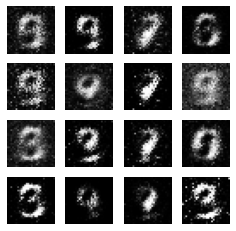

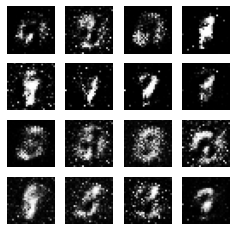

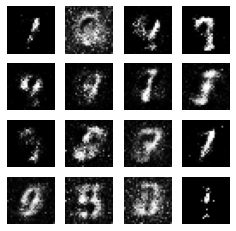

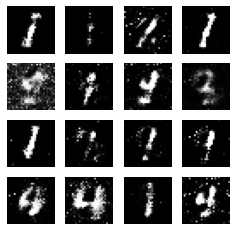

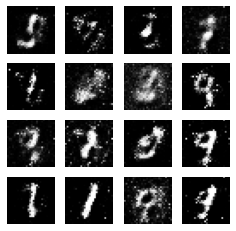

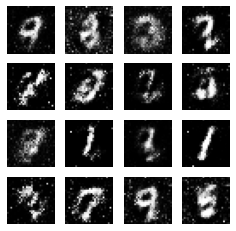

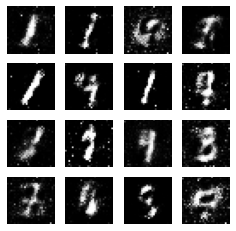

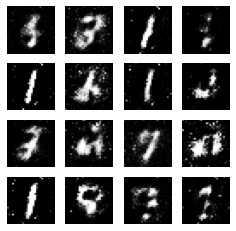

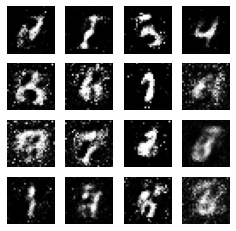

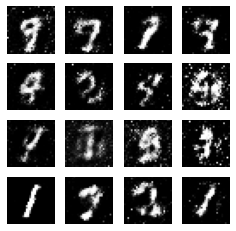

In [12]:
# Set hyperparameters
iterations = 10000
batch_size = 256
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

### Deep Convolutional Approach DCGAN

Build generator 

###### (Using Bach Normalization only in Generator inorder to speedup training, basically to have higher learning rate and normalized input in every layers)

In [15]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(7 * 7 *256, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

Build Discriminator

In [16]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [17]:
def build_gan(generator, discriminator):
    # Keep Discriminator’s parameters constant for Generator training
    discriminator.trainable = False
    
    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [19]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    # X_train = X_train / 127.5 - 1.0
    X_train = (X_train - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------
        discriminator.trainable=True

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

1000 [D loss: 0.230075, acc.: 90.62%] [G loss: 2.755938]
2000 [D loss: 0.501959, acc.: 77.34%] [G loss: 1.419366]
3000 [D loss: 0.460855, acc.: 80.08%] [G loss: 1.616759]
4000 [D loss: 0.548740, acc.: 75.39%] [G loss: 1.535401]
5000 [D loss: 0.395941, acc.: 82.03%] [G loss: 2.213036]
6000 [D loss: 0.408965, acc.: 82.42%] [G loss: 1.749680]
7000 [D loss: 0.385699, acc.: 83.98%] [G loss: 1.910813]
8000 [D loss: 0.369261, acc.: 81.25%] [G loss: 1.823055]
9000 [D loss: 0.374325, acc.: 83.20%] [G loss: 1.866199]
10000 [D loss: 0.346897, acc.: 85.55%] [G loss: 2.131217]
11000 [D loss: 0.382669, acc.: 82.81%] [G loss: 1.968095]
12000 [D loss: 0.366345, acc.: 82.81%] [G loss: 1.985280]
13000 [D loss: 0.417670, acc.: 80.86%] [G loss: 1.751533]
14000 [D loss: 0.390824, acc.: 83.20%] [G loss: 1.951808]
15000 [D loss: 0.355457, acc.: 81.64%] [G loss: 1.775932]
16000 [D loss: 0.386936, acc.: 80.86%] [G loss: 1.939802]
17000 [D loss: 0.397916, acc.: 80.86%] [G loss: 1.857023]
18000 [D loss: 0.360945

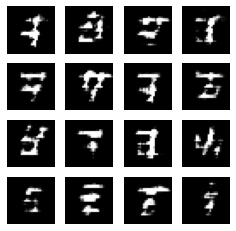

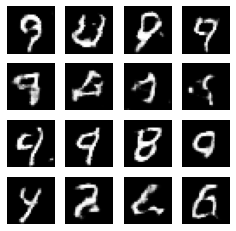

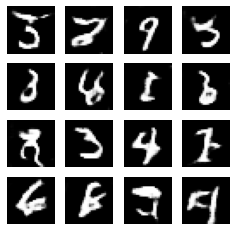

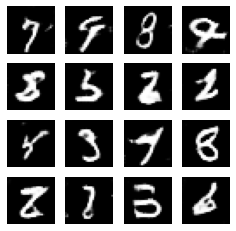

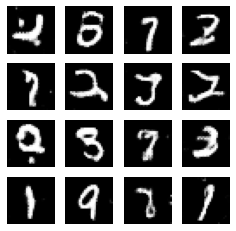

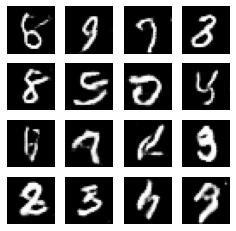

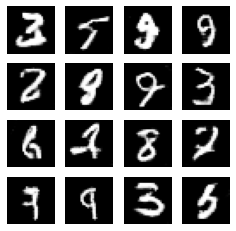

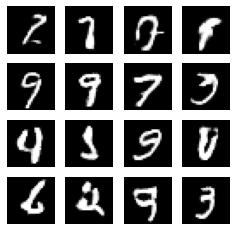

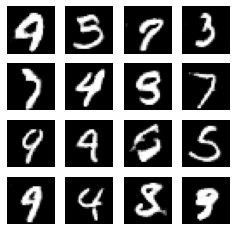

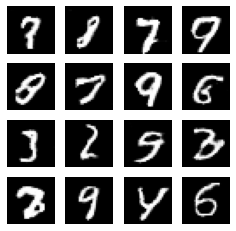

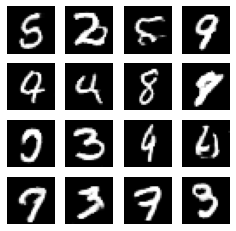

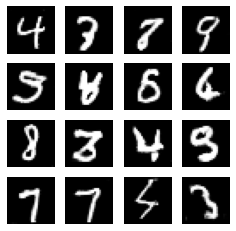

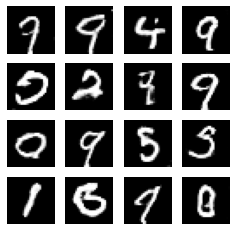

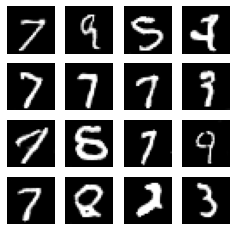

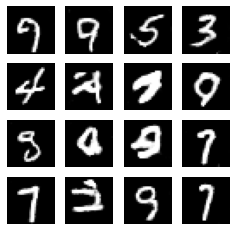

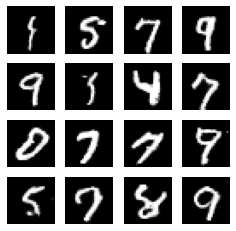

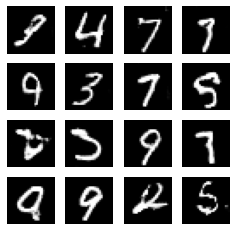

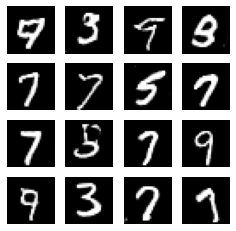

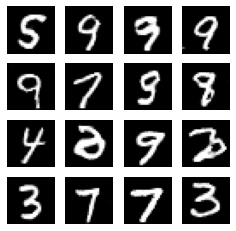

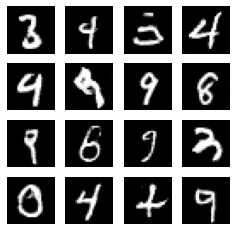

In [21]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)